## Heterogeneous Autoregressive (HAR) model

In [137]:
import torch
import torch.nn as nn
import numpy as np

In [138]:
import pandas as pd 
import matplotlib.pyplot as plt 
import datetime
from datetime import date, time

#Install Yahoo Finance Libraries
try:
  import yfinance
except:
  !pip install -q yfinance 
  import yfinance 

try:
  import yahoofinancials
except:
  !pip install -q yahoofinancials 
  import yahoofinancials 

import yfinance as yf
from yahoofinancials import YahooFinancials

In [165]:
df = yf.download('TSLA',
                 start='2000-01-01',
                 end=date.today(),
                 progress=False,)

In [166]:
df.head()


Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,,
2010-06-29 00:00:00+00:00,1.592667,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30 00:00:00+00:00,1.588667,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01 00:00:00+00:00,1.464000,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02 00:00:00+00:00,1.280000,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06 00:00:00+00:00,1.074000,1.074000,1.333333,1.055333,1.333333,103003500


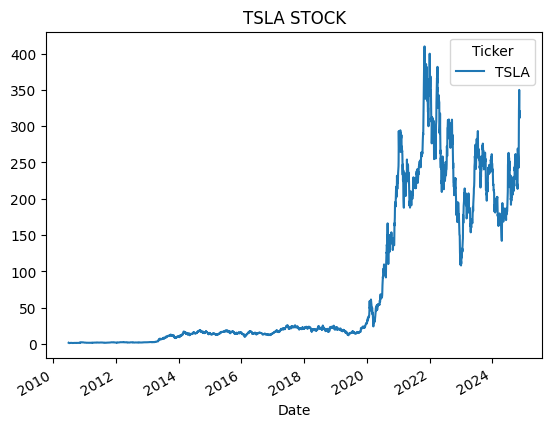

In [167]:
df.plot(y='Close', title='TSLA STOCK')
plt.show()

In [168]:
df['LABEL'] = np.where( df['Open'].shift(-2).gt(df['Open'].shift(-1)),"1","0")
df = df.dropna()
df.head()

Price,Adj Close,Close,High,Low,Open,Volume,LABEL
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA,
Date,,,,,,,
2010-06-29 00:00:00+00:00,1.592667,1.592667,1.666667,1.169333,1.266667,281494500,0
2010-06-30 00:00:00+00:00,1.588667,1.588667,2.028000,1.553333,1.719333,257806500,0
2010-07-01 00:00:00+00:00,1.464000,1.464000,1.728000,1.351333,1.666667,123282000,0
2010-07-02 00:00:00+00:00,1.280000,1.280000,1.540000,1.247333,1.533333,77097000,0
2010-07-06 00:00:00+00:00,1.074000,1.074000,1.333333,1.055333,1.333333,103003500,0


In [169]:
df.describe()

Price,Adj Close,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA,TSLA
count,3622.000000,3622.000000,3622.000000,3622.000000,3622.000000,3.622000e+03
mean,78.939360,78.939360,80.682804,77.118197,78.955151,9.676202e+07
std,104.149117,104.149117,106.529842,101.704417,104.215648,7.800935e+07
min,1.053333,1.053333,1.108667,0.998667,1.076000,1.777500e+06
25%,11.931833,11.931833,12.235667,11.678000,11.930667,4.865925e+07
50%,17.781667,17.781667,18.049666,17.472667,17.757999,8.201895e+07
75%,174.822498,174.822498,178.232498,171.889999,174.735001,1.224991e+08
max,409.970001,409.970001,414.496674,405.666656,411.470001,9.140820e+08


In [170]:
prices = df['Adj Close'].values
dates = df.index.values

## HAR Volatility

Based on this link: 
https://www.stavrianoseconblog.eu/2024/07/blog-post.html

related: https://arxiv.org/abs/2205.07719



In [171]:
returns = np.log(prices[1:]/prices[:-1])
# this data uses inter-day
volatility = returns ** 2
volatility

array([[6.32340080e-06],
       [6.67863492e-03],
       [1.80398076e-02],
       ...,
       [2.82308057e-05],
       [3.53408063e-03],
       [9.11857166e-04]])

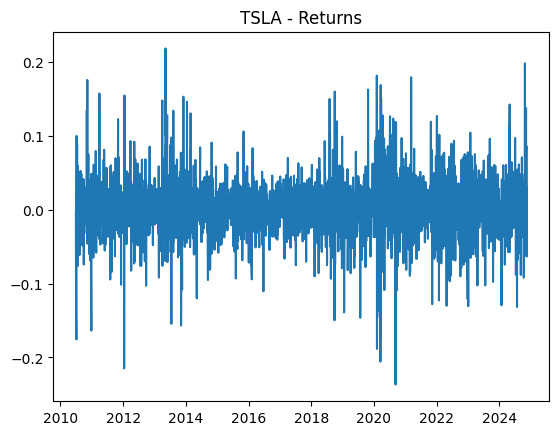

In [172]:
plt.plot(dates[1:], returns)
plt.title("TSLA - Returns")
plt.show()

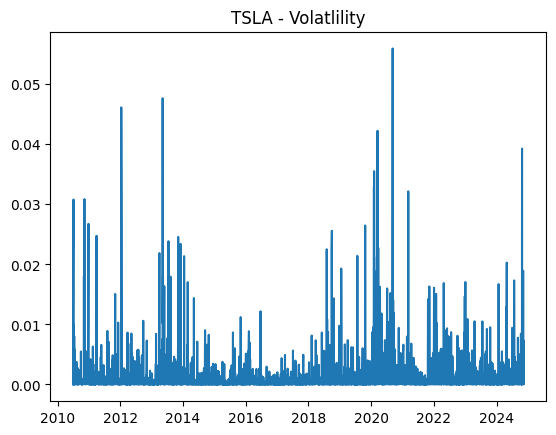

In [173]:
plt.plot(dates[1:], volatility)
plt.title("TSLA - Volatlility")
plt.show()

In [174]:
prices.shape

(3622, 1)

## Neural Network

In [175]:
# have to update for batch size
class HARNeuralNetwork(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64, output_dim=1, dropout_rate=0.1):
        super(HARNeuralNetwork, self).__init__()

        self.daily_linear_layer = nn.Linear(1, 1)
        self.weekly_linear_layer = nn.Linear(5, 1)
        self.monthly_linear_layer = nn.Linear(22, 1) # can also be 21

        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.batchNorm = nn.InstanceNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout_rate)


        self.output = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        daily = self.daily_linear_layer(x[-1:].T)
        weekly = self.weekly_linear_layer(x[-5:].T)
        monthly = self.monthly_linear_layer(x[-22:].T)

        # print(daily.shape)
        # print(weekly.shape)
        # print(weekly)

        har_features = torch.cat([daily, weekly, monthly], dim=1)
        # print(har_features.shape)
        # print(har_features)

        inter1 = self.linear1(har_features)
        inter2 = self.relu(inter1)
        # print(inter2.shape)
        inter3 = self.batchNorm(inter2)
        inter4 = self.dropout(inter3)
        inter5 = self.output(inter4)

        output = nn.functional.softplus(inter5)

        return output        

## Training

### Data

In [176]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader


X_train, X_test, y_train, y_test = train_test_split(
                                    torch.tensor(prices[:-1], dtype=torch.float), 
                                    torch.tensor(volatility, dtype=torch.float), 
                                    train_size=0.7, 
                                    shuffle=False
                                    )

train_loader = DataLoader(list(zip(X_train, y_train)), shuffle=False, batch_size=64)
validation_loader = DataLoader(list(zip(X_test, y_test)), shuffle=False, batch_size=64)

### Model Training

In [177]:
model = HARNeuralNetwork()

epochs = 10
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

train_loss = []
validation_loss = []



for epoch in range(epochs):
    model.train()
    epoch_train_loss = 0
    for x_batch, y_batch in train_loader:
        # print(x_batch)
        optimizer.zero_grad()
        output = model(x_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    epoch_train_loss = epoch_train_loss/len(train_loader)
    train_loss.append(epoch_train_loss)
    
    
    model.eval()
    epoch_validation_loss = 0
    with torch.no_grad():
        for x_batch, y_batch in validation_loader:
            output = model(x_batch)
            loss = criterion(output, y_batch)
            epoch_validation_loss += loss.item()
        epoch_validation_loss = epoch_validation_loss/len(validation_loader)

    validation_loss.append(epoch_validation_loss)
    print(f'Epoch {epoch+1}/{epochs}:')
    print(f'Training Loss: {epoch_train_loss:.6f}')
    print(f'Validation Loss: {epoch_validation_loss:.6f}\n')


Epoch 1/10:
Training Loss: 0.144790
Validation Loss: 0.021814

Epoch 2/10:
Training Loss: 0.016587
Validation Loss: 0.008017

Epoch 3/10:
Training Loss: 0.007355
Validation Loss: 0.004772

Epoch 4/10:
Training Loss: 0.005477
Validation Loss: 0.003180

Epoch 5/10:
Training Loss: 0.002743
Validation Loss: 0.002377

Epoch 6/10:
Training Loss: 0.002705
Validation Loss: 0.001857

Epoch 7/10:
Training Loss: 0.001987
Validation Loss: 0.001486

Epoch 8/10:
Training Loss: 0.001731
Validation Loss: 0.001201

Epoch 9/10:
Training Loss: 0.001400
Validation Loss: 0.001005

Epoch 10/10:
Training Loss: 0.001320
Validation Loss: 0.000831



/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/talldarkandhandsome/.pyenv/versions/3.10.0/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([38, 1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to inco

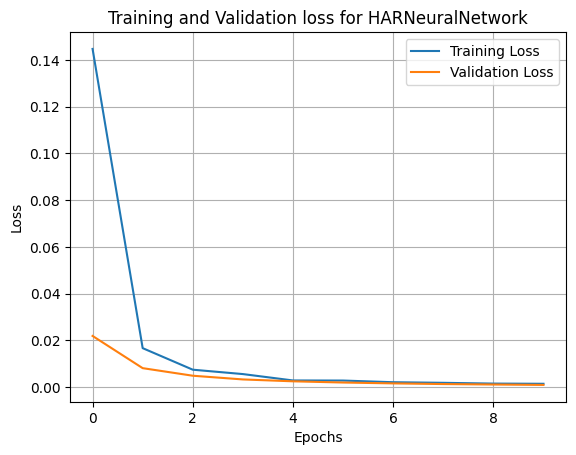

In [178]:
plt.plot(range(epochs), train_loss, label='Training Loss')
plt.plot(range(epochs), validation_loss, label='Validation Loss')
plt.title("Training and Validation loss for HARNeuralNetwork")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()